In [1]:
# magic to reload modules when they change
%load_ext autoreload
%autoreload 2

# Dynamic Analysis of a bridge structure

## Geometry of the bridge

In [2]:
import os
import time
import shutil
import logging
import numpy as np
import sympy as sp
import pandas as pd
import matplotlib.pyplot as plt
from sympy import Matrix, lambdify
from utils.truss_geometric import *
from utils.simple_beam_constraints import *
from utils.truss_helpers import *
from utils.simple_beam_analysis import define_forces, direct_assemble_global_matrices, direct_apply_boundary_conditions
from utils.simple_beam_helper import calculate_simple_essential_elements, calculate_simple_element_node, boundary_conditions_simple, insert_simple_node
from sympy.utilities.codegen import codegen
import cython 

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(message)s')

In [3]:
### Paper experiment BM2
span = 1.4
skip_rod = []
diag, height = None, None
real_inertia = 73365 * 10**-12

## Change the beam properties
unit_weight_properties['beam'] = unit_weight_steel
elastic_mod_properties['beam'] = elastic_mod
width_properties['beam'] = width_beam
height_properties['beam'] = height_beam

# Note simple and simple_cant use different functions 
# Bridge functions are defined instead in truss_helpers
truss_mode = "simple" # warren, pratt, howe, simple, simple_cant 

# You can specify beam_partition or provide custom spacings or column placements
beam_partition = 1  # Number of divisions in the beam
cantilever_sides = 2 # Beams on the edge of the bridge

# Optionally, specify custom column placements. Default is []
col_placements = [0, 1.4]
spacing = 0.35

# Calculate essential elements
n_columns, n_nod_tot, n_rods, n_beams, n_ele_tot, n_bot_beams = calculate_simple_essential_elements(
    span, spacing, truss_mode, beam_partition=beam_partition, cantilever_sides=cantilever_sides)
spacing = span / n_beams

# Calculate nodal coordinates and element relations
nodal_coord, par, pel, ele_nod, n_par_tot = calculate_simple_element_node(
    span, spacing, n_dim, n_par_nod, truss_mode, beam_partition=beam_partition)

print(f"There are {n_columns} columns, {n_beams} beams, {n_nod_tot} nodes, {n_ele_tot} elements.")


# Seperating nodal coordinates into x and y coordinates
X = np.zeros(n_nod_tot, dtype=float)
Y = np.zeros(n_nod_tot, dtype=float)
X[:] = nodal_coord[:, 0]
Y[:] = nodal_coord[:, 1]


# -------- BOUNDARY CONDITIONS --------
W = boundary_conditions_simple(spacing, n_par_nod, n_nod_tot, n_columns, col_placements, 
                                cantilever_sides, beam_partition, truss_mode,  supports=["pin", "roller"])


# # -------- ELEMENT CHARACTERIZING DATA --------
h = np.zeros(n_ele_tot, dtype=np.float32)
J = np.zeros(n_ele_tot, dtype=np.float32)
A = np.zeros(n_ele_tot, dtype=np.float32)
beta = np.zeros(n_ele_tot,dtype=np.float32)
ro = np.zeros(n_ele_tot,dtype=np.float32)
E = np.zeros(n_ele_tot, dtype=np.float32)


# # -------- ELEMENT PROPERTIES --------
J, A, h, beta, ro, E, G = calculate_element_properties(n_ele_tot, n_columns, n_beams, diag, spacing, height, 
                                                       J, A, h, beta, ro, E, X, Y, ele_nod, shear_mod,
                                                       width_properties, height_properties, unit_weight_properties, 
                                                       elastic_mod_properties, truss_mode, beam_partition)


# # -------- Insert node --------
node_pos = span / 2
X, h, J, A, beta, ro, E, G, pel, par, ele_nod, W, n_ele_tot, n_par_tot, n_nod_tot = insert_simple_node(node_pos, X, n_par_nod,
                                                                                            h, [J, A, beta, ro, E, G],
                                                                                            [pel, par, ele_nod], W, n_ele_tot, n_par_tot, n_nod_tot)
n_beams = n_ele_tot

print(f"After insertion, there are {n_columns} columns, {n_beams} beams, {n_nod_tot} nodes, {n_ele_tot} elements.")

# Replace all the inertia values with the proper value
J = np.full_like(J, real_inertia)

pel = pel.astype(np.int32)
W = W.astype(np.int32)
ele_nod = ele_nod.astype(np.int32)

beam_indices = np.arange(n_ele_tot - n_rods, dtype=np.int32)
rod_indices = np.arange(n_ele_tot - n_rods, n_ele_tot, dtype=np.int32)
X_col, Y_col = col_pos(W, n_par_nod, X, Y)

There are 5 columns, 4 beams, 5 nodes, 4 elements.
Attempted node insertion. Node already exists
After insertion, there are 5 columns, 4 beams, 5 nodes, 4 elements.


In [4]:
X, h, W, beam_partition, truss_mode, len(W), J, E

(array([0.  , 0.35, 0.7 , 1.05, 1.4 ]),
 array([0.35, 0.35, 0.35, 0.35], dtype=float32),
 array([1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]),
 1,
 'simple',
 15,
 array([7.3365e-08, 7.3365e-08, 7.3365e-08, 7.3365e-08], dtype=float32),
 array([1.83e+08, 1.83e+08, 1.83e+08, 1.83e+08], dtype=float32))

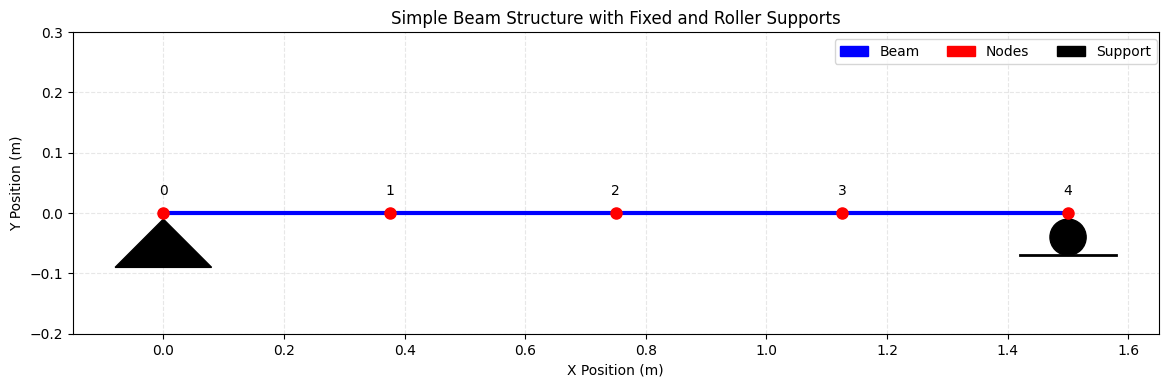

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches

# Create figure and axis
fig, ax = plt.subplots(figsize=(12, 5))

# Beam length and node positions
beam_length = 1.5
num_nodes = 5
node_positions = np.linspace(0, beam_length, num_nodes)

# Plot the beam (blue line)
ax.plot([0, beam_length], [0, 0], 'b-', linewidth=3)

# Add nodes as red circles
for i, x in enumerate(node_positions):
    ax.plot(x, 0, 'ro', markersize=8, zorder=3)
    ax.text(x, 0.03, str(i), ha='center', fontsize=10, zorder=4)

# Fixed support (left end) - properly positioned below the beam
support_offset = -0.01  # Increased offset to prevent overlap
triangle_height = 0.08
triangle_width = 0.08
triangle = plt.Polygon([[0, support_offset], 
                        [-triangle_width, support_offset-triangle_height], 
                        [triangle_width, support_offset-triangle_height]], 
                      color='black', fill=True, zorder=2)
ax.add_patch(triangle)

# Roller support (right end) - properly positioned with clear roller indication
roller_offset = -0.01  # Increased offset
roller_radius = 0.03
# Add the roller circle
circle = plt.Circle((beam_length, roller_offset-roller_radius), roller_radius, 
                   color='black', fill=True, zorder=2)
ax.add_patch(circle)
# Add base line for roller support (separate from the circle)
ax.plot([beam_length-0.08, beam_length+0.08], 
        [roller_offset-2*roller_radius, roller_offset-2*roller_radius], 
        'k-', linewidth=2, zorder=1)

# Create legend with proper colors matching the actual elements
beam_patch = mpatches.Patch(color='blue', label='Beam')
node_patch = mpatches.Patch(color='red', label='Nodes')
fixed_patch = mpatches.Patch(color='black', label='Support')

# Place legend at the top with enough space to avoid overlap with the plot
ax.legend(handles=[beam_patch, node_patch, fixed_patch], 
          loc='upper center', bbox_to_anchor=(0.85, 1), ncol=4)

# Set limits to ensure all elements are visible without crowding
ax.set_xlim(-0.15, beam_length+0.15)
ax.set_ylim(-0.2, 0.3)
ax.set_xlabel('X Position (m)', fontsize=10)
ax.set_ylabel('Y Position (m)', fontsize=10)
ax.set_title('Simple Beam Structure with Fixed and Roller Supports', fontsize=12)

# Use a light grid for better readability
ax.grid(True, linestyle='--', alpha=0.3)

# Set aspect ratio that's suitable for beam structures (slightly stretched)
ax.set_aspect('equal')

plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to make room for title and legend
plt.show()

## Bridge displacements and matrix construction

In [6]:
# Predefining the symbols and equations for the beam and rod elements
beam_type = "bernoulli"
use_lagrangian = False

(x, xi, h_e, beta_e, beta_curr, qe, a_arr, b_arr,
    c_arr, d_arr, e_arr, A_e, E_e, J_e, ro_e, T, fo_E, X_old, Y_old,
        Qglo_pel_curr, w_arr, r_arr, f_arr, g_arr) = initialize_symbols(n_par_ele)

v1, u1, v2, u2 = compute_v_u(qe, beta_e)


(ve_beam_func, ue_beam_func, ve_beam, ue_beam, ve_rod_func, 
    ue_rod_func, ve_rod, ue_rod, alpha_e_beam) = calculate_displacement_equations(x, xi, h_e, beta_e, qe, a_arr, b_arr, c_arr, d_arr, e_arr,
                                     beam_type, use_lagrangian)

pot_beam, kin_beam, pot_rod, kin_rod = calculate_energies(beam_type, ve_beam, ue_beam, alpha_e_beam, ve_rod,
                                                          ue_rod, x, h_e, E_e, J_e, A_e, ro_e, G, k_shear)

(K_beam, M_beam, K_rod, M_rod, K_beam_func, M_beam_func, 
 K_rod_func, M_rod_func) = construct_lambdified_matrices(n_par_ele, pot_beam, kin_beam, pot_rod, kin_rod, 
                                                         qe, h_e, A_e, E_e, J_e, beta_e, ro_e)



(X_new_beam, Y_new_beam, X_new_rod, Y_new_rod, X_new_beam_func, Y_new_beam_func, 
 X_new_rod_func, Y_new_rod_func) = calculate_global_displacements(Qglo_pel_curr, beta_e, h_e, x, xi, f_arr, 
                                                                         g_arr, w_arr, r_arr, beam_type,
                                                                         X_old, Y_old, use_lagrangian)


In [7]:
from IPython.display import display, Math
from sympy import pretty_print, latex

# Display matrices symbolically
print("\nBeam Stiffness Matrix (Symbolic):")
display(Math(latex(K_beam)))


Beam Stiffness Matrix (Symbolic):


<IPython.core.display.Math object>

In [8]:
%%capture
# Turn the symbolic functions into lambdified functions suitable for Cython
functions = [
    ("K_beam_func", K_beam),
    ("M_beam_func", M_beam),
    ("K_rod_func", K_rod),
    ("M_rod_func", M_rod),
]

# Generate C code
codegen(
    functions,
    language="C",
    project="utils/cython",
    to_files=True
)

functions = [
    ("X_beam_func", X_new_beam),
    ("Y_beam_func", Y_new_beam),
    ("X_rod_func", X_new_rod),
    ("Y_rod_func", Y_new_rod),
]

# Generate C code
codegen(
    functions,
    language="C",
    project="utils/cython",
    to_files=True
)

def replace_include_guards(file_path):
    with open(file_path, 'r') as file:
        content = file.read()
    
    # Replace slashes with underscores in the include guards
    content = content.replace('UTILS/CYTHON__', 'UTILS_CYTHON__')
    
    # Add whitespace after the define directive if missing
    content = content.replace('#defineUTILS_CYTHON__', '#define UTILS_CYTHON__')
    
    with open(file_path, 'w') as file:
        file.write(content)

# Paths to the header files
header_files = [
    "K_beam_func.h",
    "X_beam_func.h"
]

# Move the generated C files and modify the include guards in the header files
import os
import shutil

for header_file in header_files:
    source_path = header_file
    dest_path = os.path.join("utils/cython", header_file)
    
    # Replace include guards
    replace_include_guards(source_path)
    
    # Move the header file to the destination
    shutil.move(source_path, dest_path)

# Move the generated C files
shutil.move("K_beam_func.c", "utils/cython/K_beam_func.c")
shutil.move("X_beam_func.c", "utils/cython/X_beam_func.c")

!cd utils/cython && python setup.py build_ext --inplace

from utils.cython.assemble_matrices import assemble_global_matrices_cython, apply_boundary_conditions_cython, compute_element_matrices_cython, compute_element_coordinates_cython

In [9]:
# Construct stiffness using Cython
element_matrices = compute_element_matrices_cython(
    n_ele_tot, beam_indices, rod_indices,
    h, A, E, J, beta, ro
)
K, M = assemble_global_matrices_cython(element_matrices, pel, n_par_tot)
K, M = apply_boundary_conditions_cython(K, M, W, tol=1e-5)

# ## Same commands as above, but using the Python implementation
# K, M = assemble_global_matrices(n_par_ele, n_par_tot, n_ele_tot, K_beam_func, M_beam_func, K_rod_func, M_rod_func,
#                                 h, A, E, J, beta, ro, pel, n_rods)
# K, M = apply_boundary_conditions(K, M, W, tol=1e-5)

In [10]:
check_matrix(K) 
check_matrix(M)
W

Matrix is symmetric.
Matrix is well-conditioned (Condition number: 5.44e+07).
Matrix is positive definite.
Number of rows not diagonally dominant: 6
Matrix is symmetric.
Matrix is well-conditioned (Condition number: 3.67e+03).
Matrix is positive definite.
Number of rows not diagonally dominant: 5


array([1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0])

In [11]:
print_matrix(M)
print_matrix(K)

                 1        2        3        4        5        6        7        8        9       10       11       12       13       14       15
        1  7.2e-02  0.0e+00  0.0e+00  0.0e+00  0.0e+00  0.0e+00  0.0e+00  0.0e+00  0.0e+00  0.0e+00  0.0e+00  0.0e+00  0.0e+00  0.0e+00  0.0e+00
        2  0.0e+00  7.2e-02  0.0e+00  0.0e+00  0.0e+00  0.0e+00  0.0e+00  0.0e+00  0.0e+00  0.0e+00  0.0e+00  0.0e+00  0.0e+00  0.0e+00  0.0e+00
        3  0.0e+00  0.0e+00  5.1e-05  0.0e+00  4.8e-04 -3.8e-05  0.0e+00  0.0e+00  0.0e+00  0.0e+00  0.0e+00  0.0e+00  0.0e+00  0.0e+00  0.0e+00
        4  0.0e+00  0.0e+00  0.0e+00  2.9e-02  0.0e+00  0.0e+00  7.3e-03  0.0e+00  0.0e+00  0.0e+00  0.0e+00  0.0e+00  0.0e+00  0.0e+00  0.0e+00
        5  0.0e+00  0.0e+00  4.8e-04  0.0e+00  3.3e-02  0.0e+00  0.0e+00  5.7e-03 -4.8e-04  0.0e+00  0.0e+00  0.0e+00  0.0e+00  0.0e+00  0.0e+00
        6  0.0e+00  0.0e+00 -3.8e-05  0.0e+00  0.0e+00  1.0e-04  0.0e+00  4.8e-04 -3.8e-05  0.0e+00  0.0e+00  0.0e+00  0.0e+00  0.

In [12]:
### Direct stiffness method
K_direct = direct_assemble_global_matrices(n_ele_tot, n_par_tot, n_ele_tot,
                                  ele_nod, h, E, J, A, beta, pel)
K_direct = direct_apply_boundary_conditions(K_direct, W)
print_matrix(K_direct)

                 1        2        3        4        5        6        7        8        9       10       11       12       13       14       15
        1  1.7e+06  0.0e+00  0.0e+00  0.0e+00  0.0e+00  0.0e+00  0.0e+00  0.0e+00  0.0e+00  0.0e+00  0.0e+00  0.0e+00  0.0e+00  0.0e+00  0.0e+00
        2  0.0e+00  1.7e+06  0.0e+00  0.0e+00  0.0e+00  0.0e+00  0.0e+00  0.0e+00  0.0e+00  0.0e+00  0.0e+00  0.0e+00  0.0e+00  0.0e+00  0.0e+00
        3  0.0e+00  0.0e+00  1.5e+02  0.0e+00 -6.6e+02  7.7e+01  0.0e+00  0.0e+00  0.0e+00  0.0e+00  0.0e+00  0.0e+00  0.0e+00  0.0e+00  0.0e+00
        4  0.0e+00  0.0e+00  0.0e+00  1.7e+06  0.0e+00  0.0e+00 -8.4e+05  0.0e+00  0.0e+00  0.0e+00  0.0e+00  0.0e+00  0.0e+00  0.0e+00  0.0e+00
        5  0.0e+00  0.0e+00 -6.6e+02  0.0e+00  7.5e+03  0.0e+00  0.0e+00 -3.8e+03  6.6e+02  0.0e+00  0.0e+00  0.0e+00  0.0e+00  0.0e+00  0.0e+00
        6  0.0e+00  0.0e+00  7.7e+01  0.0e+00  0.0e+00  3.1e+02  0.0e+00 -6.6e+02  7.7e+01  0.0e+00  0.0e+00  0.0e+00  0.0e+00  0.

In [13]:
### Solve the displacement for STEEL BM2
force_nod_idx = [2] # There are 5 nodes, 2 is the 3rd node (0-indexed)
force_par = [0, 1.7, 0]
ext_forces = define_forces(W, force_nod_idx, force_par, n_par_nod)

# Convert ext_forces to column vector (n,1) shape
ext_forces = ext_forces.reshape(-1, 1)

# Solve the displacement
disp = np.linalg.solve(K, ext_forces)
disp_direct = np.linalg.solve(K_direct, ext_forces)

# Calculate the vertical displacement equations:
hashed_equations = {
    0.9: [0.7679, -12.24, 8.94, 3.00],
    1.7: [1.7721, -21.98, 15.83, 5.14],
    2.2: [2.296, -30.86, 22.37, 6.97],
    2.7: [2.6951, -38.66, 28.1, 8.57],
    3.0: [2.8666, -44.29, 32.39, 9.75],
}

deflection_arr = np.zeros((n_nod_tot-2, 1))
for i in range(0, n_nod_tot-2):
    coeff_pow = 3
    for coeff in hashed_equations[force_par[1]]:
        deflection_arr[i] += coeff * X[i]**coeff_pow
        coeff_pow -= 1


# Show relevant displacements only
show_disp = disp[1::n_par_nod]*10**3
show_disp = np.concatenate([show_disp[1:3], show_disp[3:-1]], axis=0)
show_disp_direct = disp_direct[1::n_par_nod]*10**3
show_disp_direct = np.concatenate([show_disp_direct[1:3], show_disp_direct[3:-1]], axis=0)
show_disp, deflection_arr

(array([[4.97649333],
        [7.23853622],
        [4.97649333]]),
 array([[5.14      ],
        [8.06392879],
        [6.0586303 ]]))

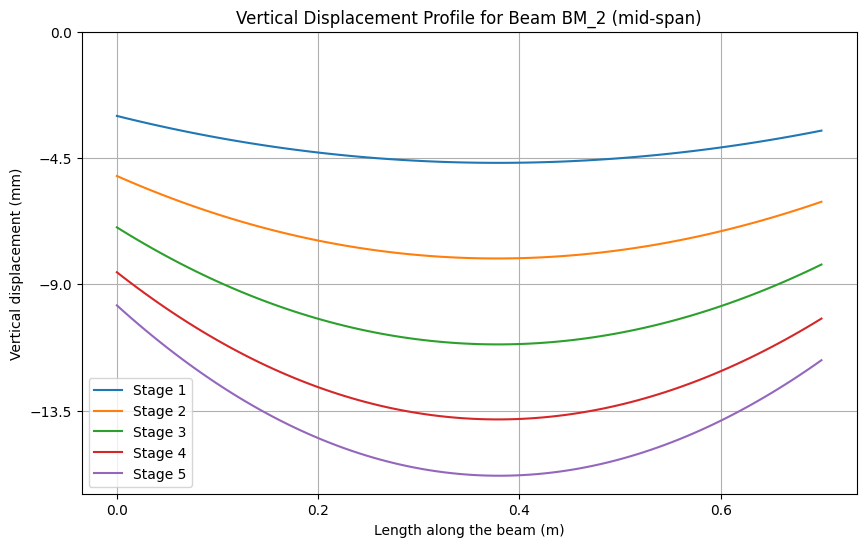

In [14]:
# Coefficients for different stages from the paper for BM_2
coefficients = {
    "Stage 1": [0.7679, -12.24, 8.94, 3.00],
    "Stage 2": [1.7721, -21.98, 15.83, 5.14],
    "Stage 3": [2.2960, -30.86, 22.37, 6.97],
    "Stage 4": [2.6951, -38.66, 28.10, 8.57],
    "Stage 5": [2.8666, -44.29, 32.39, 9.75]
}

x_plot = np.linspace(X[0], X[-3], 100)
# x_plot = np.linspace(0, X[-1], 100)
# Plot displacement profiles for each stage
plt.figure(figsize=(10, 6))
for stage, coeff in coefficients.items():
    a, b, c, d = coeff
    y_values = -(a * x_plot**3 + b * x_plot**2 + c * x_plot + d)
    plt.plot(x_plot, y_values, label=f'{stage}')

plt.xlabel('Length along the beam (m)')
plt.ylabel('Vertical displacement (mm)')
plt.xticks(np.arange(0, 0.8, 0.2))
plt.yticks(np.arange(0, -18, -4.5))
plt.title('Vertical Displacement Profile for Beam BM_2 (mid-span)')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Calculate the theoretical mid-span deflection
mid_deflection_formula = force_par[1] * span**3 / (48 * E[0] * J[0]) * 10**3

# Extract displacement values
theoretical = mid_deflection_formula
numerical_disp = show_disp[1][0]
direct_disp = show_disp_direct[1][0]
deflection = deflection_arr[1][0]

# Calculate percentage differences
perc_diff_disp = ((numerical_disp - theoretical) / theoretical) * 100
perc_diff_direct = ((direct_disp - theoretical) / theoretical) * 100
perc_diff_deflection = ((deflection - theoretical) / theoretical) * 100

# Create a DataFrame to display the results
data = {
    'Method': ['Theoretical Displacement', 'Energy method Displacement', 'Direct Stiffness Displacement', 'Photogrammetry Displacement'],
    'Deflection (mm)': [theoretical, numerical_disp, direct_disp, deflection],
    '% Difference': [0, perc_diff_disp, perc_diff_direct, perc_diff_deflection]
}

df = pd.DataFrame(data)

# Display the table
df

,Method,Deflection (mm),% Difference
0,Theoretical Displacement,7.238553,0.000000
1,Energy method Displacement,7.238536,-0.000235
2,Direct Stiffness Displacement,7.238551,-0.000024
3,Photogrammetry Displacement,8.063929,11.402493


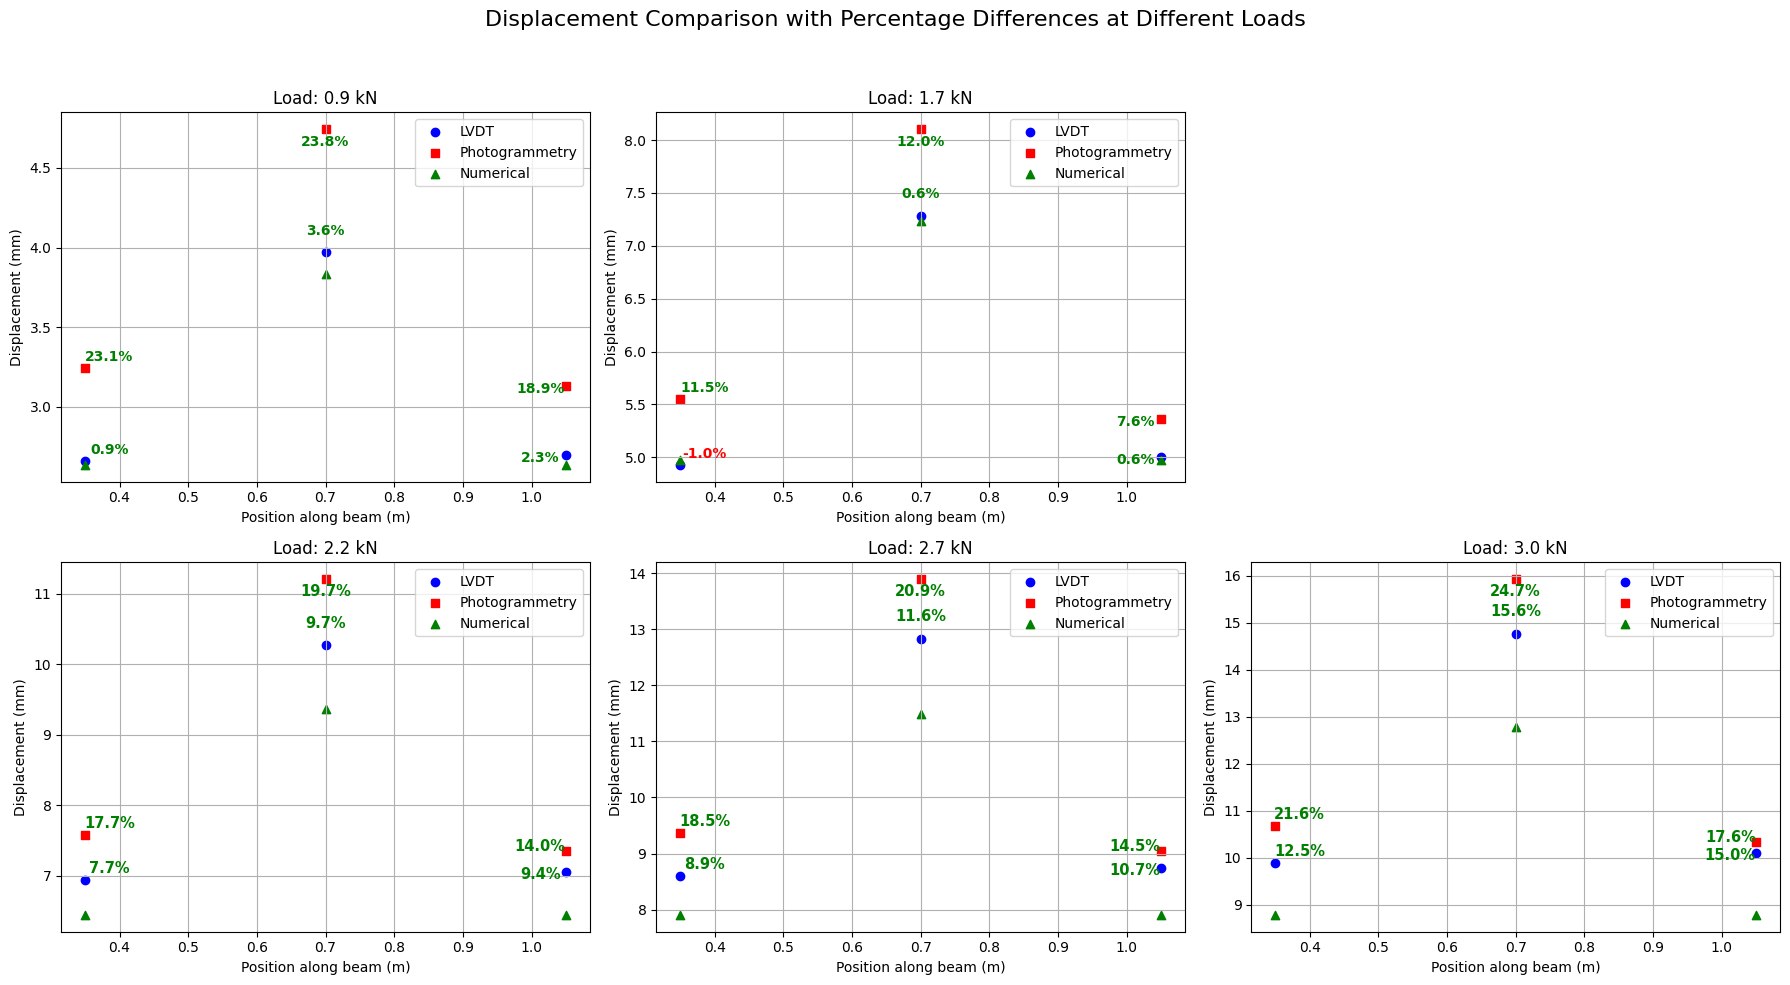

In [30]:
# Calculate the % difference between the 2 LVDT and photogrammetry results with the theoretical results and plot them
lvdt_disp = np.array([
    [2.659, 3.970, 2.696],
    [4.927, 7.284, 5.004],
    [6.939, 10.273, 7.046],
    [8.605, 12.831, 8.748],
    [9.880, 14.768, 10.097]
])
fotogrammetry_disp = np.array([
    [3.242, 4.744, 3.132],
    [5.548, 8.104, 5.357],
    [7.582, 11.211, 7.343],
    [9.368, 13.896, 9.050],
    [10.681, 15.930, 10.331]
])

force_nod_idx = [2]
p_arr = [0.9, 1.7, 2.2, 2.7, 3.0]

# Calculate the numerical mid-span deflection by solving the system
numerical_disp = np.zeros(fotogrammetry_disp.shape)

for i, p_curr in enumerate(p_arr):
    force_par = [0, p_curr, 0]
    ext_forces = define_forces(W, force_nod_idx, force_par, n_par_nod)
    ext_forces = ext_forces.reshape(-1, 1)  # Convert to column vector
    disp = np.linalg.solve(K, ext_forces)
    
    # Extract displacement values (e.g. selecting proper DOFs)
    disp_temp = disp[1::n_par_nod] * 10**3  # Scaling to mm
    # Rearrange if needed: here we take nodes 2,3 then 4, etc.
    disp_temp = np.concatenate([disp_temp[1:3], disp_temp[3:-1]], axis=0)
    numerical_disp[i] = disp_temp.flatten()

# X coordinates for the points (e.g. nodes 2,3,4)
x_coords = X[1:4]
markers = ['o', 's', '^']
colors = ['blue', 'red', 'green']

# Compute percentage differences relative to numerical_disp
lvdt_diff_pct = (lvdt_disp - numerical_disp) / numerical_disp * 100
fotogrammetry_diff_pct = (fotogrammetry_disp - numerical_disp) / numerical_disp * 100

# Set up the figure and GridSpec layout
fig = plt.figure(figsize=(18, 10))
gs = fig.add_gridspec(2, 3, height_ratios=[1, 1])  # Two rows: first row with 2 subplots, second row with 3

# First row: load stages 1 and 2
for i in range(2):
    ax = fig.add_subplot(gs[0, i])
    ax.scatter(x_coords, lvdt_disp[i], marker=markers[0], color=colors[0], label='LVDT')
    ax.scatter(x_coords, fotogrammetry_disp[i], marker=markers[1], color=colors[1], label='Photogrammetry')
    ax.scatter(x_coords, numerical_disp[i], marker=markers[2], color=colors[2], label='Numerical')
    
    for j, x in enumerate(x_coords):
        lvdt_diff = lvdt_diff_pct[i, j]
        foto_diff = fotogrammetry_diff_pct[i, j]
        
        if j == 0:
            lvdt_xytext = (17.5, 5)
            foto_xytext = (17.5, 5)
        elif j == 1:
            lvdt_xytext = (0, 12.5)
            foto_xytext = (0, -12.5)
        else:
            lvdt_xytext = (-18.5, -5)
            foto_xytext = (-18.5, -5)
            
        lvdt_color = 'green' if lvdt_diff >= 0 else 'red'
        foto_color = 'green' if foto_diff >= 0 else 'red'
        
        ax.annotate(f'{lvdt_diff:.1f}%', (x, lvdt_disp[i, j]), textcoords="offset points", xytext=lvdt_xytext,
                    ha='center', color=lvdt_color, fontsize=10, fontweight='bold')
        ax.annotate(f'{foto_diff:.1f}%', (x, fotogrammetry_disp[i, j]), textcoords="offset points", xytext=foto_xytext,
                    ha='center', color=foto_color, fontsize=10, fontweight='bold')
    
    ax.set_title(f'Load: {p_arr[i]} kN')
    ax.set_xlabel('Position along beam (m)')
    ax.set_ylabel('Displacement (mm)')
    ax.grid(True)
    ax.legend()

# Second row: load stages 3 to 5
for i in range(2, 5):
    ax = fig.add_subplot(gs[1, i - 2])
    ax.scatter(x_coords, lvdt_disp[i], marker=markers[0], color=colors[0], label='LVDT')
    ax.scatter(x_coords, fotogrammetry_disp[i], marker=markers[1], color=colors[1], label='Photogrammetry')
    ax.scatter(x_coords, numerical_disp[i], marker=markers[2], color=colors[2], label='Numerical')
    
    for j, x in enumerate(x_coords):
        lvdt_diff = lvdt_diff_pct[i, j]
        foto_diff = fotogrammetry_diff_pct[i, j]
        
        if j == 0:
            lvdt_xytext = (17.5, 5)
            foto_xytext = (17.5, 5)
        elif j == 1:
            lvdt_xytext = (0, 12.5)
            foto_xytext = (0, -12.5)
        else:
            lvdt_xytext = (-18.5, -5)
            foto_xytext = (-18.5, 0)
            
        lvdt_color = 'green' if lvdt_diff >= 0 else 'red'
        foto_color = 'green' if foto_diff >= 0 else 'red'
        
        ax.annotate(f'{lvdt_diff:.1f}%', (x, lvdt_disp[i, j]), textcoords="offset points", xytext=lvdt_xytext,
                    ha='center', color=lvdt_color, fontsize=10.5, fontweight='bold')
        ax.annotate(f'{foto_diff:.1f}%', (x, fotogrammetry_disp[i, j]), textcoords="offset points", xytext=foto_xytext,
                    ha='center', color=foto_color, fontsize=10.5, fontweight='bold')
    
    ax.set_title(f'Load: {p_arr[i]} kN')
    ax.set_xlabel('Position along beam (m)')
    ax.set_ylabel('Displacement (mm)')
    ax.grid(True)
    ax.legend()

fig.suptitle('Displacement Comparison with Percentage Differences at Different Loads', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In [ ]:
# Print percentage differences for each load stage and measurement
print("\nPercentage Differences for Each Load Stage:\n")
for i, load in enumerate(p_arr):
    print(f"Load: {load} kN")
    print("  LVDT % Difference:", [f"{diff:.2f}%" for diff in lvdt_diff_pct[i]])
    print("  Photogrammetry % Difference:", [f"{diff:.2f}%" for diff in fotogrammetry_diff_pct[i]])
    print()

"""
The comparison of theoretical and experimental displacement measurements for a simply supported steel beam under incremental loading reveals critical insights:

LVDT vs. Theoretical Displacements:

LVDT Measurements: Across the range of applied loads, LVDT displacement measurements demonstrate strong agreement with theoretical predictions, especially at lower load stages where differences stay within ±3%. At higher loads (above 2.2 kN), the percentage difference increases to 8–15%, yet remains within an acceptable engineering tolerance for such measurements.
Interpretation: The close alignment between LVDT results and theoretical values suggests that the theoretical model effectively represents the beam’s behavior under these load conditions. Minor deviations, especially at higher loads, may stem from elastic deformation limits or slight nonlinearities that are inherent in real materials under substantial bending stresses.
Photogrammetry vs. Theoretical Displacements:

Photogrammetry Measurements: The photogrammetry results exhibit significant discrepancies compared to theoretical values, particularly at lower loads. For instance, at 0.9 kN, photogrammetry readings deviate by approximately 18–24%, which decreases marginally as the load increases, but still remains high, with 15–25% deviation at maximum load (3.0 kN).
Engineering Implications: The substantial differences suggest that photogrammetry may not be as reliable as LVDT for accurately capturing small displacements in this beam setup, possibly due to precision limitations when measuring minor deflections. For a steel beam, which has a relatively high modulus of elasticity, initial deformations under lower loads are minimal, requiring high precision to accurately capture small displacements. Photogrammetry appears more prone to errors in these conditions, leading to notable inaccuracies.
Structural Considerations:

Material Response and Calibration: Given the stiffness of a simply supported steel beam, even minor calibration errors in photogrammetry could lead to amplified inaccuracies. Steel beams have predictable linear-elastic behavior up to certain load thresholds; hence, the observed theoretical displacements are likely accurate for these loading scenarios. The reliability of LVDT readings confirms this, while photogrammetry’s larger discrepancies may reflect sensitivity to setup variables, especially under lower displacement conditions.
Practical Use for Load Monitoring: For engineering applications requiring real-time monitoring of beam displacements, LVDT measurements appear to offer a more consistent and dependable method than photogrammetry in this case. Photogrammetry may still be useful for larger deformations or less rigid structures, where setup sensitivities and precision requirements are less stringent.
Conclusion:
The analysis suggests that while theoretical predictions reliably approximate the beam’s behavior, photogrammetry measurements may not be optimal for monitoring small deflections in a stiff structure like a steel beam. LVDT provides a higher level of accuracy under these conditions, with minor deviations that fall within engineering tolerances. For practical applications involving steel beams or similar rigid elements, LVDT is recommended over photogrammetry for displacement measurement, particularly when high precision is essential in the initial, low-load regime. Photogrammetry could, however, be improved with enhanced calibration and environmental controls if required for similar applications.
"""


Percentage Differences for Each Load Stage:

Load: 0.9 kN
  LVDT % Difference: ['0.93%', '3.60%', '2.33%']
  Photogrammetry % Difference: ['23.05%', '23.79%', '18.88%']

Load: 1.7 kN
  LVDT % Difference: ['-0.99%', '0.63%', '0.55%']
  Photogrammetry % Difference: ['11.48%', '11.96%', '7.65%']

Load: 2.2 kN
  LVDT % Difference: ['7.75%', '9.67%', '9.41%']
  Photogrammetry % Difference: ['17.73%', '19.68%', '14.02%']

Load: 2.7 kN
  LVDT % Difference: ['8.87%', '11.61%', '10.68%']
  Photogrammetry % Difference: ['18.52%', '20.87%', '14.50%']

Load: 3.0 kN
  LVDT % Difference: ['12.50%', '15.61%', '14.97%']
  Photogrammetry % Difference: ['21.62%', '24.71%', '17.64%']



## Solve the eigenvalue problem

In [58]:
# Compute eigenvalues and eigenvectors using scipy method without filtering
lamb_r, phis_norm = compute_eigenvalues_and_eigenvectors(K, M, method='numpy', filter_numerical_stability=True, threshold=1e-10)
index_modes, sorted_period, _ = get_mode_indices(lamb_r, phis_norm, n_plots)

# Extract lambdas and corresponding eigenvectors
lamb_plots = lamb_r[index_modes]
phis_plots = phis_norm[:, index_modes]

# Print sorted periods
print("Sorted Periods:", sorted_period)
print("Selected Modes Periods:", sorted_period[index_modes])
print(f"The frequencies of the first {n_plots} plots are {np.sqrt(lamb_r[index_modes])}")

Sorted Periods: [6.2831852e-05 6.2831852e-05 6.2831852e-05 1.0234403e-03 3.5752764e-03
 5.9319907e-03 1.0814764e-02 2.7183803e-02 1.2021263e-01]
Selected Modes Periods: [0.12021263 0.0271838  0.01081476 0.00593199]
The frequencies of the first 4 plots are [  52.267265  231.1371    580.98224  1059.2035  ]


## Bridge Output for Mode Shapes

In [60]:
# Compute the displacement of each node for each mode using Cython
X_new_sub, Y_new_sub, X_disp, Y_disp = compute_element_coordinates_cython(
    n_plots, n_ele_tot, n_rods, n_discritizations, span, spacing,
    X, Y, ele_nod, beta, h, pel, phis_plots, use_lagrangian
)


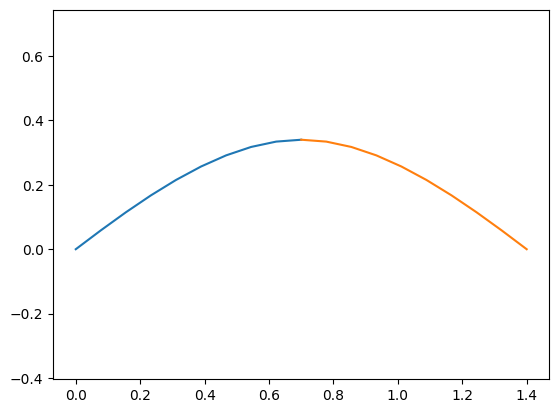

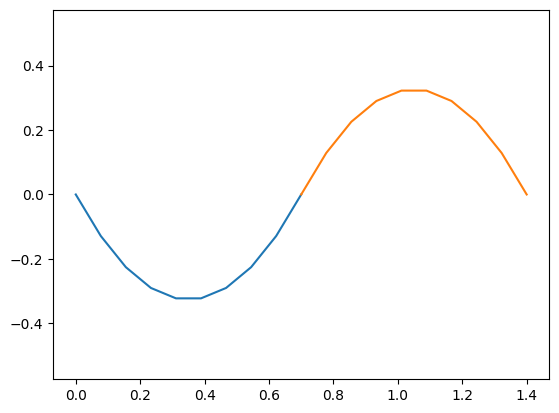

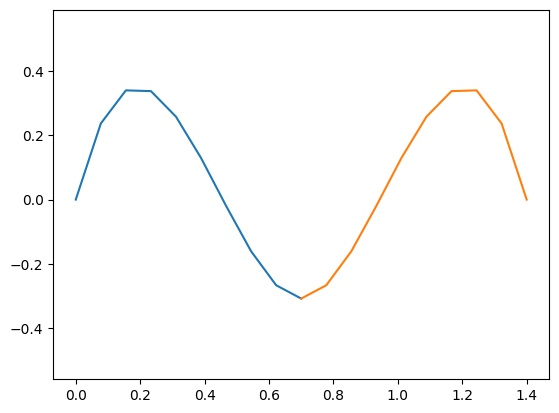

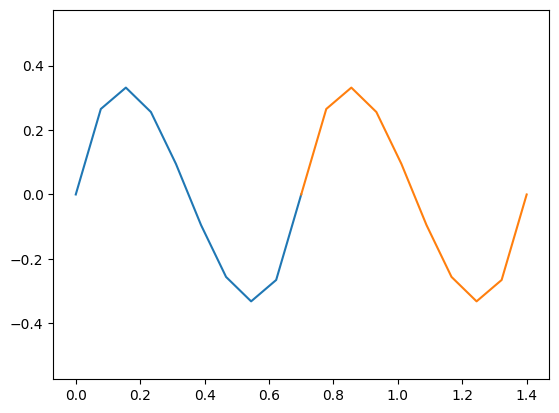

In [61]:
# Define lists
X_new_sub = np.zeros((n_plots, n_ele_tot, n_discritizations))
Y_new_sub = np.zeros((n_plots, n_ele_tot, n_discritizations))
X_disp = np.zeros((n_plots, n_ele_tot))
Y_disp = np.zeros((n_plots, n_ele_tot))

amplifier = int(span / spacing) * 0.1

# Iterate over n_plots and n_ele_tot
for j in range(n_plots):
    plt.figure()  # Create a new figure for each mode
    for e in range(n_ele_tot):
        # Choose beam or rod functions
        if e < n_ele_tot - n_rods:
            x_func = X_new_beam_func
            y_func = Y_new_beam_func
        else:
            x_func = X_new_rod_func
            y_func = Y_new_rod_func

        # Prepare arguments for the lambda functions
        func_args = (
            X[ele_nod[e, 0]],
            Y[ele_nod[e, 0]],
            beta[e],
            h[e],
        ) + tuple(phis_plots[pel[e, i]-1, j]*amplifier for i in range(n_par_ele))

        # Generate plot values
        if use_lagrangian:
            plot_values = np.linspace(0, 1, 10)
        else:
            plot_values = np.linspace(0, h[e], 10)

        # Calculate new coordinates
        X_new_sub[j][e] = x_func(plot_values, *func_args)
        Y_new_sub[j][e] = y_func(plot_values, *func_args)

        plt.plot(X_new_sub[j][e], Y_new_sub[j][e])  # Plot elements for the current mode

        # Save the displacement in the X direction
        X_disp[j, e] = X_new_sub[j][e][-1] - X_new_sub[j][e][0]
        Y_disp[j, e] = Y_new_sub[j][e][-1] - Y_new_sub[j][e][0]

    plt.axis('equal')  # Make x and y axes have the same scale
    plt.show()  # Display the plot for the current mode

In [44]:
# Get dimension of X_disp
X_disp.shape, phis_plots.shape, X_disp[0], X_disp[1]

((39, 4),
 (63, 4),
 array([2.49710688, 2.51107104, 2.39769564, 2.46241069]),
 array([2.4932581 , 2.51996989, 2.40834231, 2.47984783]))